----
# 1. 필요 라이브러리 불러오기 
----

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
tqdm.pandas()

tqdm은 pandas에서 진행상황을 확인할 수 있는 코드이며, tqdm을 어느 이터러블이든 감싸서 사용 하면 된다.

----
# 2. 데이터 전처리 하기 
----

----
# 2-1. 데이터 정보 및 중복값 제거
----

In [2]:
data = pd.read_csv('/content/drive/MyDrive/aiffel/EXP 11/ChatbotData.txt')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


 - dataset 정보 확인

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


전체 데이터 수 11823개 이며, 질문(Q)과 답변(A)로 구성되어 있다.  
label의 경우 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링 되어 있다.

- Null값 확인

In [4]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

- 중복값 확인

In [5]:
data.duplicated().sum()

0

전체적으로 보면 중복값은 없으나, 컬럼별로 확인해볼 경우 있을 수 있으니 다시 확인해보겠다.

In [6]:
data['Q'].duplicated().sum()

161

In [7]:
data[data['Q'].duplicated()]

,Q,A,label
196,고양이 키우고 싶어,가족들과 상의해보세요.,0
235,공시 준비 힘들어,잘 될 거예요.,0
1294,돈 벌고 싶어,많이 벌수록 좋아요.,0
1445,로또 번호 알려줘,알면 제가 하죠.,0
1481,마음이 울적해,거리를 걸어보세요.,0
...,...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.,2
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.,2
11658,첫사랑 생각나,지금의 사랑에 충실하세요.,2
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.,2


In [8]:
data[data['Q'] == '고양이 키우고 싶어']

,Q,A,label
195,고양이 키우고 싶어,자신을 먼저 키우세요.,0
196,고양이 키우고 싶어,가족들과 상의해보세요.,0


In [9]:
data[data['Q'] == '공시 준비 힘들어']

,Q,A,label
234,공시 준비 힘들어,합격 기원해요!,0
235,공시 준비 힘들어,잘 될 거예요.,0


In [10]:
data[data['Q'] == '훔쳐보는 것도 눈치 보임.']

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2


질문은 같으나 답변이 다른 경우가 대부분인 것 같다.  
찾고자 하는 값은 Q컬럼과 A컬럼이 중복인 경우를 찾고 확인해보겠다.

In [11]:
data.duplicated(subset = ['Q','A']).sum()

73

Q와 A가 중복이 되는 컬럼이 73개가 발견 되었다.

In [12]:
data[data.duplicated(subset = ['Q','A'])]

,Q,A,label
5527,결혼이나 하지 왜 자꾸 나한테 화 내냐구!,힘들겠네요.,1
5537,고백하고 후회하면 어떡하지,후회는 후회를 낳을뿐이에요. 용기 내세요.,1
5542,공부는 내 체질이 아닌 것 같아,확신이 없나봐요.,1
5704,기숙사 괜찮을까,혼자 사는 것보다 불편하겠죠.,1
5774,나는 좋은데 ….,현실의 벽에 부딪혔나봐요.,1
...,...,...,...
8764,환승 가능?,환승은 30분 안에,1
8780,회사 사람들이 아직도 불편해,회사에는 동료가 있을 뿐이에요.,1
8782,회사에는 왜 친구 같은 사람이 없을까,회사는 친구 사귀는 곳이 아니에요.,1
8789,후련하달까,후련하니 다행이에요.,1


In [13]:
data[data['Q'] == '환승 가능?']

,Q,A,label
5207,환승 가능?,환승은 30분 안에,0
8764,환승 가능?,환승은 30분 안에,1


In [14]:
data[data['Q'] == '결혼이나 하지 왜 자꾸 나한테 화 내냐구!']

,Q,A,label
152,결혼이나 하지 왜 자꾸 나한테 화 내냐구!,힘들겠네요.,0
5527,결혼이나 하지 왜 자꾸 나한테 화 내냐구!,힘들겠네요.,1


2가지 컬럼에서 중복된 값을 찾았으나 해당 값들은 label의 내용이 달랐다.  
추후 챗봇 모델을 만들고 학습하는데 있어서 label값은 중요하지 않다고 판단하고, 중복값을 삭제해주겠다.

In [15]:
data.drop_duplicates(subset = ['Q','A'], keep ='first',inplace=True )
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [16]:
data.reset_index(inplace=True)

In [17]:
data.shape

(11750, 4)

73개의 중복값이 삭제 된것을 확인할 수 있다.

----
# 2-2. 정규표현식을 활용한 데이터 전처리
----

- 영어가 포함된 문장 확인 

In [18]:
data[data['Q'].str.contains('[a-zA-Z]')]

,index,Q,A,label
4,4,PPL 심하네,눈살이 찌푸려지죠.,0
5,5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0
10,10,SNS보면 나만 빼고 다 행복해보여,자랑하는 자리니까요.,0
754,754,남친 SNS에 내 사진 없어,신경쓰지 마세요.,0
762,762,남친이 SNS에 내 사진에 안 올려,신경쓰지 마세요.,0
5420,5420,jk김동욱 노래 생각나네,가사가 비슷한가봐요.,1


대부분의 영어는 의미가 있는 것으로 파악되며, 7번 인덱스의 ㅠㅠ같은 문자는 삭제해주는 것이 옳다고 판단된다.

In [19]:
data[data['Q'].str.contains('[0-9]')]

,index,Q,A,label
0,0,12시 땡!,하루가 또 가네요.,0
1,1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
176,176,고3은 공부만 해야겠지.,공부가 최우선이죠.,0
...,...,...,...,...
10677,10750,연애한지 2년째야,딱 좋을 때네요.,2
10875,10948,자기를 3인칭으로 말하는 여자친구의 말투가 고민임.,귀엽게 봐주세요.,2
11111,11184,좋아하는 애가 1년만 기다려 달라는데 어쩌지.,기다릴 수 있다면 본인 의지대로 하셔요.,2
11317,11390,짝남이 내가 좋아하는걸 1도 몰라.,1은 알게 해야죠.,2


- ? . ! 를 제외하고 포함된 특수문자가 무엇이 있는지 확인

In [20]:
data[data['Q'].str.contains('[-=+,#/\:^$@*\"※~&%ㆍ』\\‘|\(\)\[\]\<\>`\'…》]')]


,index,Q,A,label
592,592,나는 좋은데 ….,현실의 벽에 부딪혔나봐요.,0
1398,1398,떠나요~ 제주도~,여행 좋죠!,0
1902,1902,바람쐬러 정동진가~~,잘 놀다 오세요.,0
2059,2059,베터리 15%야,미리 충전하세요.,0
2060,2060,베터리 겨우 15%야,미리 충전하세요.,0
...,...,...,...,...
8681,8745,"혼자 있고싶다는 남자친구, 인정하기가 힘이 드네",시간을 좀 주세요.,1
8740,8812,휴~~ 이제 글쓰는것도 멈춰야 할까,글 쓰면서 정리가 되기도 해요.,1
8747,8819,흐잌~~ 불금이닷~~ㅠㅠ,퐈이야,1
8774,8846,"힘들고, 힘들고, 또 힘들고,",억지로라도 힘내보세요.,1


~(물결) 같은 경우는 삭제 시키지 않아도 크게 의미가 없어 보이며 2개씩 사용하는 것들도 많아서 삭제 처리 해주는 것이 옳다고 판단된다.

In [21]:
data[data['Q'].str.contains('[…]')]

,index,Q,A,label
592,592,나는 좋은데 ….,현실의 벽에 부딪혔나봐요.,0
5299,5299,15년…안녕,시간이 무색하네요.,1


In [22]:
data[data['A'].str.contains('[…]')]


,index,Q,A,label
4749,4749,컴퓨터가 느려졌어,뭘 다운 받으신 건지…,0
4750,4750,컴퓨터가 대빵 느려졌어,뭘 다운 받으신 건지…,0


... 같은 경우 문장에서 의미가 있다고 생각했지만 전체 데이터 중 컬럼별로 2개씩 밖에 없기 때문에 삭제 처리 해주는 것이 옳다고 판단된다.

In [23]:
data[data['Q'].str.contains('[%]')]

,index,Q,A,label
2059,2059,베터리 15%야,미리 충전하세요.,0
2060,2060,베터리 겨우 15%야,미리 충전하세요.,0


%의 경우 2개의 데이터 밖에 없지만 배터리를 표시함에 있어 중요한 단어라고 생각되 살려주도록 하겠다.

In [24]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,%])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (ㄱ-ㅎ, 가-힣, ".", "?", "!", ",", "%")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^0-9a-zA-Zㄱ-ㅎ가-힣?.!,%]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [25]:
print("전처리 전의 질문 샘플 : ",data['Q'][0])
print("전처리 후의 질문 샘플 : ", preprocess_sentence(data['Q'][0]))
print('='*50)
print("전처리 전의 질문 샘플 : ",data['Q'][4])
print("전처리 후의 질문 샘플 : ", preprocess_sentence(data['Q'][4]))
print('='*50)
print("전처리 전의 질문 샘플 : ",data['Q'][2060])
print("전처리 후의 질문 샘플 : ", preprocess_sentence(data['Q'][2060]))
print('='*50)
print("전처리 전의 질문 샘플 : ",data['Q'][4])
print("전처리 후의 질문 샘플 : ", preprocess_sentence(data['Q'][4]))
print('='*50)
print("전처리 전의 답변 샘플 : ",data['A'][564])
print("전처리 후의 답변 샘플 : ", preprocess_sentence(data['A'][564]))
print('='*50)
print("전처리 전의 답변 샘플 : ",data['A'][4750])
print("전처리 후의 답변 샘플 : ", preprocess_sentence(data['A'][4750]))


전처리 전의 질문 샘플 :  12시 땡!
전처리 후의 질문 샘플 :  12시 땡 !
전처리 전의 질문 샘플 :  PPL 심하네
전처리 후의 질문 샘플 :  PPL 심하네
전처리 전의 질문 샘플 :  베터리 겨우 15%야
전처리 후의 질문 샘플 :  베터리 겨우 15 % 야
전처리 전의 질문 샘플 :  PPL 심하네
전처리 후의 질문 샘플 :  PPL 심하네
전처리 전의 답변 샘플 :  제가 따라가려면 멀었네요.
전처리 후의 답변 샘플 :  제가 따라가려면 멀었네요 .
전처리 전의 답변 샘플 :  뭘 다운 받으신 건지…
전처리 후의 답변 샘플 :  뭘 다운 받으신 건지


- 정규표현식을 통한 데이터 전처리 실행

In [26]:
def load_conversations():
    questions, answers = [], []
    for q, a in zip(data['Q'], data['A']):
        questions.append(preprocess_sentence(q))
        answers.append(preprocess_sentence(a))
        
        if len(questions) >= len(data):
            return questions, answers
    return questions, answers

In [27]:
questions, answers = load_conversations()
print('전체 질문 수 :', len(questions))
print('전체 답변 수 :', len(answers))

전체 질문 수 : 11750
전체 답변 수 : 11750


---
# 3. 단어장 만들기
----

- bulid_from_corpus 파라미터 
  - corpus_generator : (generator yielding str) 여기에서 하위 단어가 구성됩니다.
  - target_vocab_size : (int) 생성할 어휘의 대략적인 크기.
  - max_subword_length : (int) 하위 단어의 최대 길이. 메모리와 컴퓨팅은 가장 긴 토큰의 길이에 따라 2차적으로 확장됩니다.
  - max_corpus_chars : (int)corpus_generator, 하위 단어 어휘를 구축하기 위해 소비할 최대 문자 수입니다 .
  - reserved_tokens :	(list.str) 항상 전체 토큰으로 처리되고 분할되지 않는 토큰 목록입니다. 여기에는 영숫자와 영숫자가 아닌 문자가 혼합되어 있어야 합니다(예: "") 밑줄로 끝나지 않습니다.

  https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder

In [28]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers , target_vocab_size=2**13)

In [29]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [30]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8126


In [31]:
print('START_TOKEN의 번호 :' ,START_TOKEN)
print('END_TOKEN의 번호 :' ,END_TOKEN)
print('VOCAB_SIZEN의 크기 :' ,VOCAB_SIZE)

START_TOKEN의 번호 : [8124]
END_TOKEN의 번호 : [8125]
VOCAB_SIZEN의 크기 : 8126


----
# 4. 각 단어를  고유한 정수로 인코딩 및 패딩 
----

- tokenizer함수의 encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환

In [32]:
print('정수 인코딩 전의 21번째 질문 샘플: {}'.format(questions[21]))
print('정수 인코딩 전의 21번째 답변 샘플: {}'.format(answers[21]))
print('='*60)
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 전의 21번째 질문 샘플: 가스비 장난 아님
정수 인코딩 전의 21번째 답변 샘플: 다음 달에는 더 절약해봐요 .
정수 인코딩 후의 21번째 질문 샘플: [5758, 611, 2485, 4154]
정수 인코딩 후의 21번째 답변 샘플: [2343, 7475, 7, 6253, 97, 1]


- 단어 사전의 구성을 간략하게 확인

In [33]:
tokenized_string = tokenizer.encode(questions[21])
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))
print('='*20)
tokenized_string = tokenizer.encode(answers[21])
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5758 ----> 가스
611 ----> 비 
2485 ----> 장난 
4154 ----> 아님
2343 ----> 다음 
7475 ----> 달에는 
7 ----> 더 
6253 ----> 절약해
97 ----> 봐요
1 ---->  .


In [34]:
print('정수 인코딩 전의 21번째 질문 샘플: {}'.format(questions[4]))
print('정수 인코딩 전의 21번째 답변 샘플: {}'.format(answers[4]))
print('='*70)
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[4])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[4])))

정수 인코딩 전의 21번째 질문 샘플: PPL 심하네
정수 인코딩 전의 21번째 답변 샘플: 눈살이 찌푸려지죠 .
정수 인코딩 후의 21번째 질문 샘플: [7948, 7948, 7944, 7900, 4177]
정수 인코딩 후의 21번째 답변 샘플: [1106, 2283, 1489, 2169, 5457, 49, 1]


In [35]:
tokenized_string = tokenizer.encode(questions[4])
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))
print('='*20)
tokenized_string = tokenizer.encode(answers[4])
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

7948 ----> P
7948 ----> P
7944 ----> L
7900 ---->  
4177 ----> 심하네
1106 ----> 눈
2283 ----> 살이 
1489 ----> 찌
2169 ----> 푸
5457 ----> 려지
49 ----> 죠
1 ---->  .


- 최적의 패딩 값 찾기

In [36]:
total_data_text = list(data['Q']) + list(data['A'])
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  13.953276595744681
문장길이 최대 :  76
문장길이 표준편차 :  6.527697771809793
pad_sequences maxlen :  27
전체 문장의 0.9618723404255319%가 maxlen 설정값 이내에 포함됩니다. 


In [37]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 27
print(MAX_LENGTH)

27


In [38]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 28 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 28으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [39]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8126
필터링 후의 질문 샘플 개수: 11746
필터링 후의 답변 샘플 개수: 11746


-----
# 5. teacher forcing 사용하기 
----

 - 장점 = 학습이 빠르다 

 - 단점 = 노출 편향 문제 (입력으로 넣어주는 ground Truth가 추론 과정에서는 제공 되지 않아 학습과 추론 단계에서의 차이가 존재하여 모델 성능 및 안정성을 저해할 수 있다)   
   (다만 노출 편향이 생각만큼 큰 영향을 미치니지 않는다는 연구결과가 있다고 함)

In [40]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 교사강요를 위한 디코더 입력값
    },
    {
        'outputs': answers[:, 1:] # 교사강요를 위한 디코더 레이블
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

----
# 6. 모델 구성하기
----

----
# 6-1. 필요 함수 및 클래스 구성
----

- super 키워드

  super 키워드는 부모 클래스로부터 상속받은 필드나 메소드를 자식 클래스에서 참조하는 데 사용하는 참조 변수  
  부모 클래스의 멤버와 자식 클래스의 멤버 이름이 같을 경우 super 키워드를 사용하여 구별

In [41]:
###################### 포지셔널 행렬 구현하는 코드 ######################
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

- tf.cast = 텐서를 새로운 형태로 캐스팅하는데 사용
  - 부동소수점형에서 정수형으로 바꾼 경우 소수점 버림
  - Boolean형태인 경우 True이면 1, False이면 0을 출력
- tf.equal = 두 텐서의 원소가 같다면 Ture를 출력, 다르면 False
- tf.newaxis = 데이터의 size(차원)을 변경하는 방법

In [42]:
###################### 멀티 헤드 어텐션 함수 구현하기 ######################

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [43]:
###################### 스케일드 닷 프로덕트 어텐션 함수 구현하기 ###################### 

def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [44]:
###################### 멀티 헤드 어텐션 함수 구현하기 ###################### 

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

- matrix_band_part(input, num_lower, num_upper, name=None)
- tf.lingalg.band_part를 통해 다음과 같이 삼각행렬 또는 대각행렬을 구현할 수 있다
  - tf.linalg.band_part(tensor,-1,0) --> 하삼각행렬
  - tf.linalg.band_part(tensor,0,-1) --> 상삼각행렬
  - tf.linalg.band_part(tensor,0,0) --> 대각행렬

In [45]:
###################### 룩 어헤드 마스킹 어텐션 함수 구현하기 ######################

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [46]:
###################### 인코더 레이어 함수 구현하기 ######################

# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [47]:
###################### 인코더 함수 구현하기 ######################
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [48]:
###################### 디코더 레이어 함수 구현하기 ######################

# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [49]:
###################### 디코더 레이어 구현하기 ######################

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

----
# 6-2. 트랜스포머 모델 정의 및 학습
----

In [50]:
def transformer(vocab_size,num_layers,units,d_model,num_heads,dropout,name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

- 모델 학습

In [51]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입,출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3134464     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

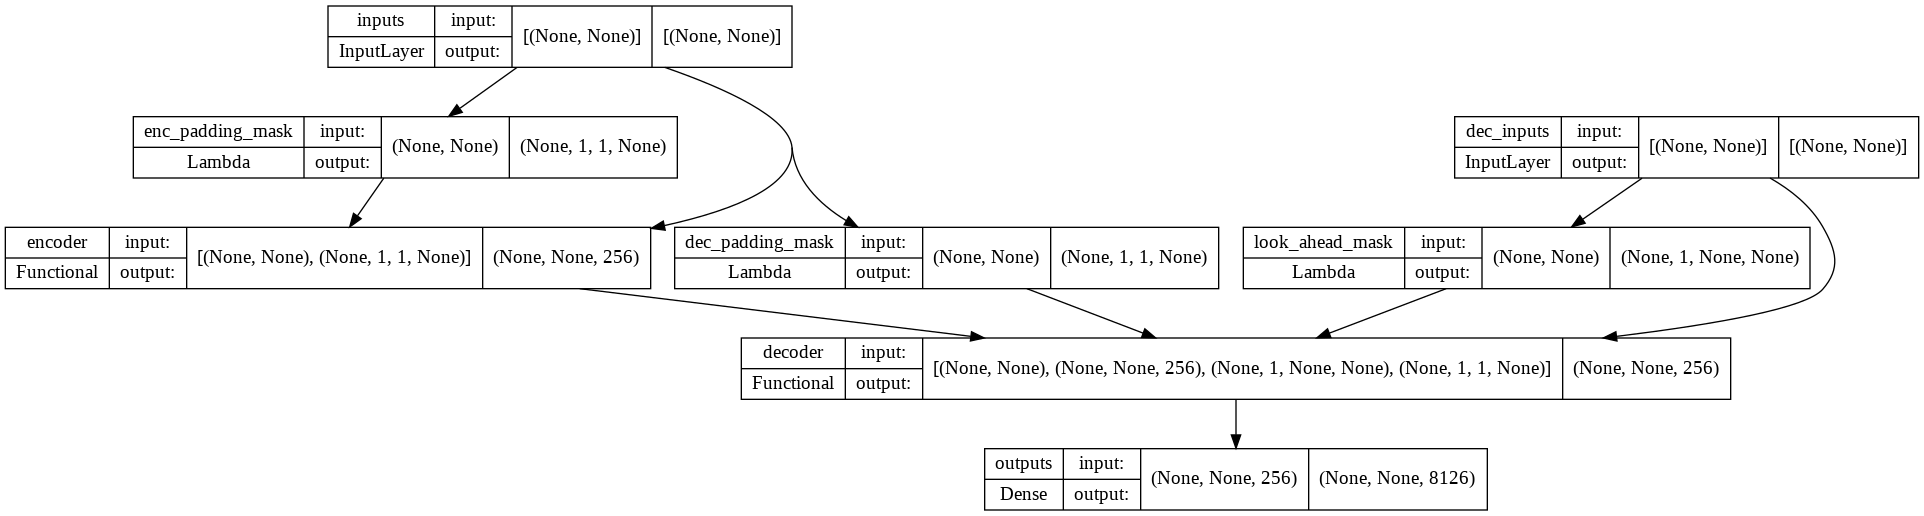

In [52]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

- 손실 학습

In [53]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

- 커스텀 학습률

In [54]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

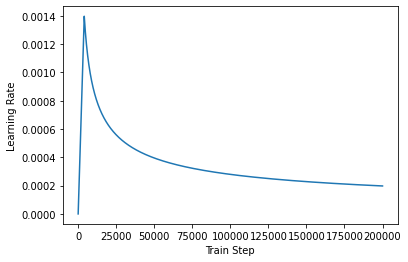

In [55]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

- Adam 옵티마이저
  - lr: 0보다 크거나 같은 float 값. 학습률.
  - beta_1: 0보다 크고 1보다 작은 float 값. 일반적으로 1에 가깝게 설정됩니다.
  - beta_2: 0보다 크고 1보다 작은 float 값. 일반적으로 1에 가깝게 설정됩니다.
  - epsilon: 0보다 크거나 같은 float형 fuzz factor.  None인 경우 K.epsilon()이 사용됩니다.
  - decay: 0보다 크거나 같은 float 값. 업데이트마다 적용되는 학습률의 감소율입니다.
  - amsgrad: 불리언. Adam의 변형인 AMSGrad의 적용 여부를 설정합니다.

  https://keras.io/ko/optimizers/

In [56]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [57]:
EPOCHS = 20
# ------------------------------------------------------------------------------------
es = EarlyStopping(monitor='loss', patience=2, verbose=1)
# ------------------------------------------------------------------------------------
history = model.fit(dataset, epochs=EPOCHS, verbose=1,callbacks=[es])

Epoch 1/20
184/184 [==============================] - 18s 54ms/step - loss: 2.1877 - accuracy: 0.0368
Epoch 2/20
184/184 [==============================] - 10s 54ms/step - loss: 1.7783 - accuracy: 0.0741
Epoch 3/20
184/184 [==============================] - 10s 54ms/step - loss: 1.5111 - accuracy: 0.0758
Epoch 4/20
184/184 [==============================] - 10s 54ms/step - loss: 1.3969 - accuracy: 0.0815
Epoch 5/20
184/184 [==============================] - 10s 54ms/step - loss: 1.3136 - accuracy: 0.0860
Epoch 6/20
184/184 [==============================] - 10s 56ms/step - loss: 1.2264 - accuracy: 0.0917
Epoch 7/20
184/184 [==============================] - 10s 54ms/step - loss: 1.1288 - accuracy: 0.1003
Epoch 8/20
184/184 [==============================] - 10s 54ms/step - loss: 1.0202 - accuracy: 0.1117
Epoch 9/20
184/184 [==============================] - 10s 53ms/step - loss: 0.9021 - accuracy: 0.1246
Epoch 10/20
184/184 [==============================] - 10s 53ms/step - loss: 0.778

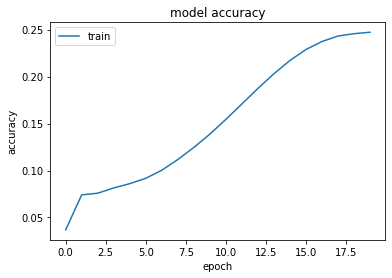

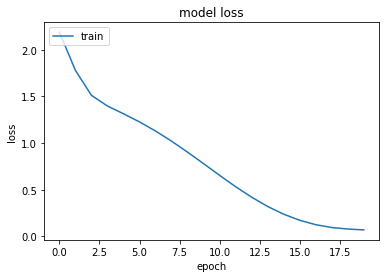

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

----
# 7. 챗봇 테스트 하기
----

In [59]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [60]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  # return predicted_sentence

In [61]:
sentence_generation('오늘 날씨가 어때?')

입력 : 오늘 날씨가 어때?
출력 : 좋은 의미를 생각해보세요 .


In [62]:
sentence_generation('이름이 뭐야?')

입력 : 이름이 뭐야?
출력 : 위로봇이요 .


In [63]:
sentence_generation('밥먹자')

입력 : 밥먹자
출력 : 맛있게 드세요 .


In [64]:
sentence_generation('돈까스 먹고싶어')

입력 : 돈까스 먹고싶어
출력 : 앞머리만이라도 감으세요 .


In [65]:
sentence_generation('심심해')

입력 : 심심해
출력 : 친구들과 연락해보세요 .


In [66]:
sentence_generation('뭘봐')

입력 : 뭘봐
출력 : 버릴 때 마음이 아프겠어요 .


In [67]:
sentence_generation('위로해줘')

입력 : 위로해줘
출력 : 그럴 수 있어요 .


조금 다른 답변을 하는 경우도 있지만 어느정도 옳바른 답변을 하는 것으로 보인다.

------
# 7-1 문제점 확인 및 이유 추측 해보기 
-----

이전의 자연어 처리에서는 padding의 값을 pre로 놓는 것이 더 좋음을 확인 할 수 있었다.   
이번 모델에서도 성능을 향상을 목적으로 padding = 'pre'로 넣어 줬지만 문장을 생성함에 있어 아래 사진과 같은 문제점을 발견할 수 있었다.

(데이터셋을 8대2로 분리 후 pre와 post를 evaluate 해본 결과 pre는 0.3586 / post는 0.1122가 나왔다)
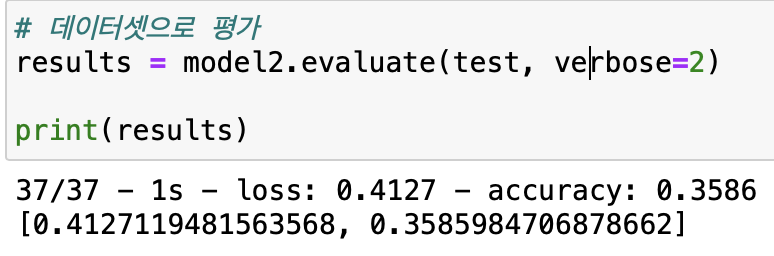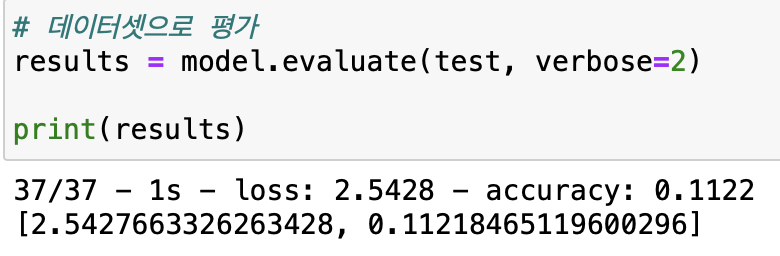

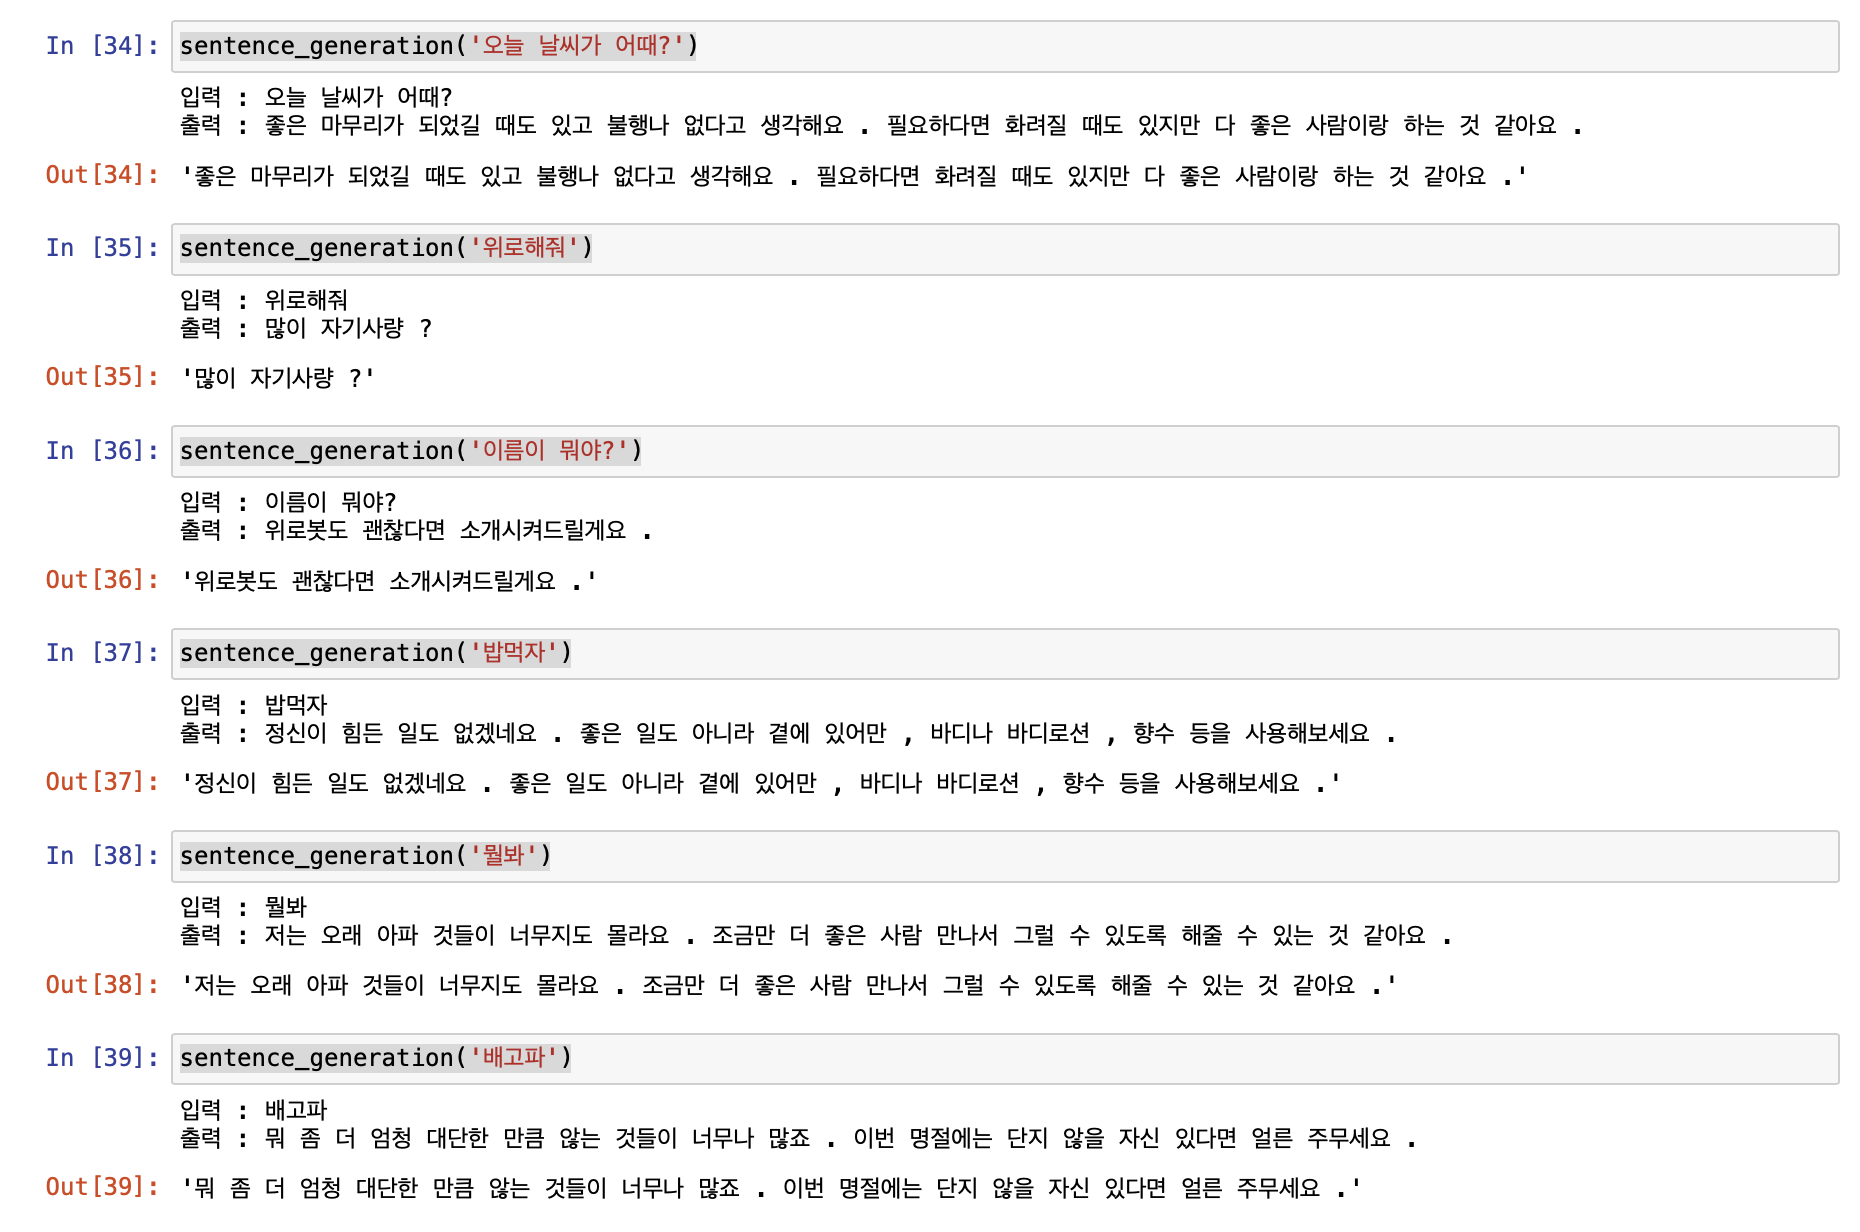

전반적인 문장을 생성함에 있어서 말이 안맞는 부분들이 많으며 , 여러 문장들이 겹쳐서 나옴을 확인 할 수 있었다.  



해당 문제에 대해서 여러가지 고민과 토론을 해본결과 가장 그럴싸한 원인을 찾게 되었다.  
교사강요(teacher forcing)을 하는 부분에서   
input의 값을 target값으로 넣어주기 위해서 start_token을 슬라이싱을 하고 있다.**(outputs': answers[:, 1:] 부분)**  
현재 코드는 패딩값을 post로 설정했을 때를 위한 코드이며,  
패딩 값을 pre로 설정했을 때는 outputs': answers[:, 1:] 코드로 start_token을 삭제하는 것은 불가능 하며, dec_inputs': answers[:, :-1] 부분에서 오히려 end_token이 삭제가 되어 문장을 뽑아낼 때 문장 생성 오류 및 여러 문장이 겹쳐서 나오는 것이라 생각된다. 



---------------- 교사 강요 코드 ----------------   

    dataset = tf.data.Dataset.from_tensor_slices((  
              'inputs': questions,  
              'dec_inputs': answers[:, :-1] # 교사강요를 위한 디코더 입력값  
              
              'outputs': answers[:, 1:] # 교사강요를 위한 디코더 레이블




- padding = 'post' 일 경우

In [205]:
# start_token = 8124 / end_totken = 8125
answers[:, :-1]

array([[8124, 3826,   76, ...,    0,    0,    0],
       [8124, 1823, 5489, ...,    0,    0,    0],
       [8124, 3371,  770, ...,    0,    0,    0],
       ...,
       [8124, 5193,  287, ...,    0,    0,    0],
       [8124,   15, 3176, ...,    0,    0,    0],
       [8124,  219,  549, ...,    0,    0,    0]], dtype=int32)

In [206]:
# start_token 삭제
answers[:, 1:]

array([[3826,   76, 7845, ...,    0,    0,    0],
       [1823, 5489,    1, ...,    0,    0,    0],
       [3371,  770,  130, ...,    0,    0,    0],
       ...,
       [5193,  287,    1, ...,    0,    0,    0],
       [  15, 3176,    4, ...,    0,    0,    0],
       [ 219,  549, 2592, ...,    0,    0,    0]], dtype=int32)

- padding = 'pre' 일 경우

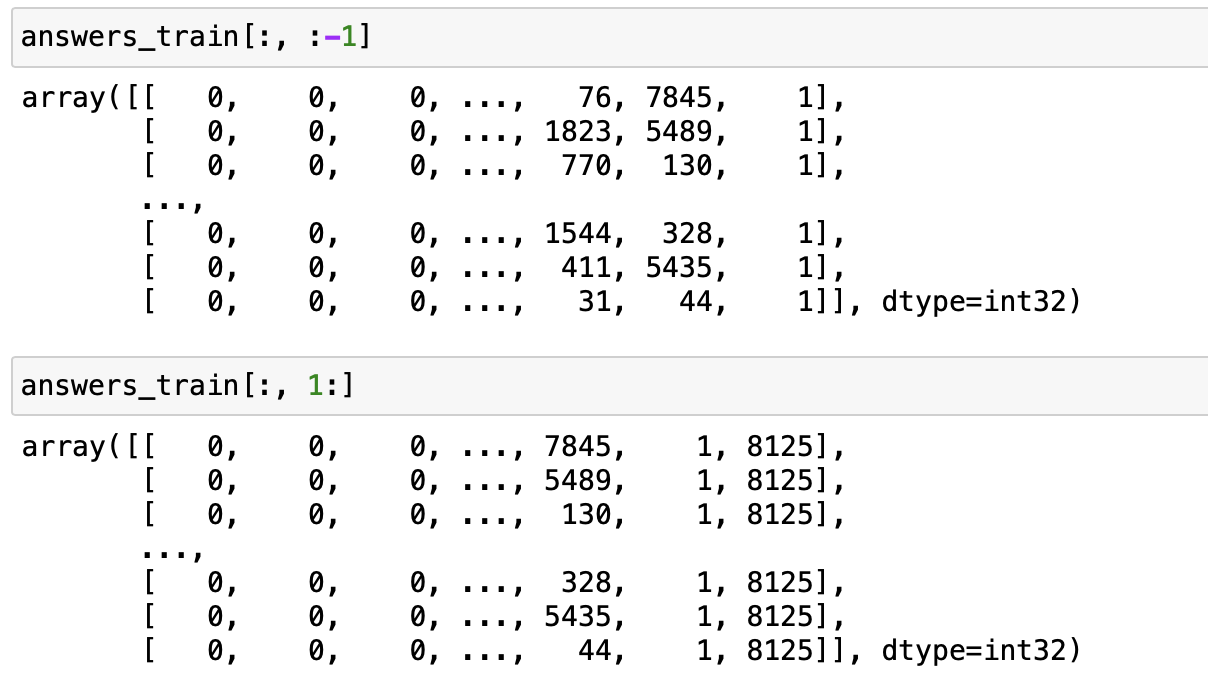

start_token은 0(패딩)때문에 슬라이싱 할 수 없고, 오히러 end_token이 삭제되는 것을 볼 수 있다.

---
# 8. 다른 모델 사용해 보기 
----

----
# 8-1 카카오의 Pororo
----

https://acdongpgm.tistory.com/224

In [68]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
# !git clone https://github.com/kakaobrain/pororo.git

In [70]:
cd /content/drive/MyDrive/aiffel/EXP 11/pororo

/content/drive/MyDrive/aiffel/EXP 11/pororo


In [71]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/aiffel/EXP%2011/pororo
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pororo
    Found existing installation: pororo 0.4.1
    Can't uninstall 'pororo'. No files were found to uninstall.
  Running setup.py develop for pororo


In [72]:
from pororo import Pororo
import pandas as pd
from sentence_transformers import util
import torch
import numpy as np

임베딩 : 모든 질문에 대한 임베딩 값을 구함. 

In [73]:
se = Pororo(task="sentence_embedding", lang="ko")

data['embedding_vectors'] = data['Q'].progress_map(lambda x : se(x))

100%|██████████| 11750/11750 [04:09<00:00, 47.08it/s]


- 데이터 변환 : 코사인 유사도를 구해주기 위해 미리 구해놓은 임베딩 데이터를 tensor로 변환

In [74]:
embedding_data = torch.tensor(data['embedding_vectors'].tolist())

- 인풋 데이터를 임베딩 하고 tensor 타입으로 변환

In [75]:
def return_sim_question(input_sentence):
  input_sentence = se(input_sentence)
  input_sentence = torch.tensor(input_sentence)
  return input_sentence

In [76]:
def chatbot_pororo(message):
  message = message.strip()
  # 입력 문장 임베딩
  embedding_sentence = return_sim_question(message)
  
  # 미리 구해진 임베딩 데이터와 현재 임베딩 데이터의 코사인 유사도 추출
  cos_sim = util.pytorch_cos_sim(embedding_sentence,embedding_data)
  cos_sim = cos_sim.cpu()
  
  #유사도가 가장 비슷한 질문 인덱스 반환
  best_sim_idx = int(np.argmax(cos_sim))
  
  #print(df['Q'][best_sim_idx])
  
  #유사도가 가장 비슷한 질문에 해당하는 답변 제공
  answer = data['A'][best_sim_idx]
  return answer

In [77]:
chatbot_pororo('제발 잠좀 자고싶어')

'생각과 걱정을 덜어보세요.'

In [78]:
chatbot_pororo('힘들다')

'힘이 되지 않겠지만 힘내세요.'

In [79]:
chatbot_pororo('제발 잊고 싶어')

'마음 먹은 것만으로도 절반을 해낸 거예요.'

In [80]:
chatbot_pororo('혼자있고 싶어')

'혼자만 있지 마세요.'

모델 구현도 트랜스포머 모델보다 간단하고 input에 대한 output문장도 더 잘 뽑아내는 느낌이다.

-----
# 8-2 koGPT2
-----

https://github.com/ukairia777/tensorflow-nlp-tutorial/blob/main/22.%20Fine-tuning%20GPT-2%20(Cls%2C%20Chatbot%2C%20NLI)/22-3.%20kogpt2_chatbot_gpu.ipynb

In [81]:
# !pip install transformers

In [82]:
import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFGPT2LMHeadModel
from tqdm.notebook import tqdm

In [83]:
tokenizer2 = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', pad_token='<pad>')
model2 = TFGPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.9.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'lm_head.weight', 'transformer.h.11.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expe

In [84]:
print(tokenizer2.bos_token_id)
print(tokenizer2.eos_token_id)
print(tokenizer2.pad_token_id)
print('-' * 10)
print(tokenizer2.decode(1))
print(tokenizer2.decode(2))
print(tokenizer2.decode(3))
print(tokenizer2.decode(4))

1
1
3
----------
</s>
<usr>
<pad>
<sys>


In [85]:
batch_size = 64

def get_chat_data():
  for question, answer in zip(data.Q.to_list(), data.A.to_list()):
    bos_token = [tokenizer2.bos_token_id]
    eos_token = [tokenizer2.eos_token_id]
    sent = tokenizer2.encode('<usr>' + question + '<sys>' + answer) 
    yield bos_token + sent + eos_token

In [86]:
dataset2 = tf.data.Dataset.from_generator(get_chat_data, output_types=tf.int32)

In [88]:
dataset2 = dataset2.padded_batch(batch_size=batch_size, padded_shapes=(None,), padding_values=tokenizer2.pad_token_id)

In [89]:
for batch in dataset2:
    print(batch)
    break

tf.Tensor(
[[    1     2  9349 ...     3     3     3]
 [    1     2  9020 ...     3     3     3]
 [    1     2  9085 ...     3     3     3]
 ...
 [    1     2 16959 ...     3     3     3]
 [    1     2 32717 ...     3     3     3]
 [    1     2 14819 ...     3     3     3]], shape=(64, 30), dtype=int32)


In [90]:
tokenizer2.decode(batch[31])

'</s><usr> 가족들이랑 서먹해졌어<sys> 다들 바빠서 이야기할 시간이 부족했나봐요.</s><pad><pad><pad><pad><pad>'

In [91]:
print(batch[0])

tf.Tensor(
[    1     2  9349  7888   739  7318   376     4 12557  6824  9108  9028
  7098 25856     1     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3], shape=(30,), dtype=int32)


In [92]:
print(tokenizer2.encode('</s><usr> 12시 땡!<sys> 하루가 또 가네요.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'))

[1, 2, 9349, 7888, 739, 7318, 376, 4, 12557, 6824, 9108, 9028, 7098, 25856, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [93]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
steps = len(data) // batch_size + 1
print(steps)

184


In [95]:
EPOCHS = 3

for epoch in range(EPOCHS):
  epoch_loss = 0

  for batch in tqdm(dataset2, total=steps):
      with tf.GradientTape() as tape:
          result = model2(batch, labels=batch)
          loss = result[0]
          batch_loss = tf.reduce_mean(loss)
          
      grads = tape.gradient(batch_loss, model2.trainable_variables)
      adam.apply_gradients(zip(grads, model2.trainable_variables))
      epoch_loss += batch_loss / steps

  print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, epoch_loss))

  0%|          | 0/184 [00:00<?, ?it/s]

[Epoch:    1] cost = 2.08878446


  0%|          | 0/184 [00:00<?, ?it/s]

[Epoch:    2] cost = 1.67573881


  0%|          | 0/184 [00:00<?, ?it/s]

[Epoch:    3] cost = 1.43577266


In [103]:
def chatbot_kogpt(user_text):
  sent = '<usr>' + user_text + '<sys>'
  input_ids = [tokenizer2.bos_token_id] + tokenizer2.encode(sent)
  input_ids = tf.convert_to_tensor([input_ids])
  output = model2.generate(input_ids, max_length=50, do_sample=True, top_k=20)
  sentence = tokenizer2.decode(output[0].numpy().tolist())
  chatbot_response = sentence.split('<sys> ')[1].replace('</s>', '')
  return chatbot_response

- 문장 생성과정 눈으로 확인해 보기 

In [181]:
text = '12시 땡!'

In [182]:
sent = '<usr>' + text + '<sys>'
sent

'<usr>12시 땡!<sys>'

In [183]:
# input문장을 토큰화
input_ids = [tokenizer2.bos_token_id] + tokenizer2.encode(sent)
input_ids = tf.convert_to_tensor([input_ids])
input_ids

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[   1,    2, 9349, 7888,  739, 7318,  376,    4]], dtype=int32)>

In [184]:
# output값을 뽑아내고 input 토큰 뒤에 붙이기
output = model2.generate(input_ids, max_length=50, early_stopping=True, eos_token_id=tokenizer2.eos_token_id)
output

<tf.Tensor: shape=(1, 13), dtype=int32, numpy=
array([[    1,     2,  9349,  7888,   739,  7318,   376,     4, 10586,
        33892,  7098, 25856,     1]], dtype=int32)>

In [100]:
# output토큰 디코딩
decoded_sentence = tokenizer2.decode(output[0].numpy().tolist())
decoded_sentence

'</s><usr> 12시 땡!<sys> 좋은 소식이네요.</s>'

In [101]:
# <sys>를 기준으로 자른 후 앞 부분은 제거하고 end token은 공백으로 처리
decoded_sentence.split('<sys> ')[1].replace('</s>', '')

'좋은 소식이네요.'

In [104]:
chatbot_kogpt('안녕')

'안녕이네요.'

In [185]:
chatbot_kogpt('심심해')

'저한테 이야기해도 되는지 모르겠네요.'

In [191]:
chatbot_kogpt('너는 누구야?')

'좋아하는 사람하고 직접적이든 직접적이든 대화를 해보세요.'

In [187]:
chatbot_kogpt('12시 땡!')

'짝사랑 많이하는게 느껴질지도 모르겠어요.'

이전 모델들과 달리 문장을 생성하는 모델이다 보니 input의 문장에 맞는 output이 나오는 것은 아님을 확인할 수 있다. 

----
# 9. 모델 비교 및 이해하기
----



1. 트랜스포머 모델
2. pororo 모델
3. koGPT 모델   
3가지의 결과물을 보고 비교를 통해 모델을 확인하고 이해해 보려한다.

-------

In [123]:
print('Transfomer: ')
sentence_generation('심심하다')
print('='*50)
print('Pororo:',chatbot_pororo('심심하다'))
print('='*50)
print('koGPT:',chatbot_kogpt('심심하다'))

Transfomer: 
입력 : 심심하다
출력 : 저랑 놀아요 .
Pororo: 저랑 놀아요.
koGPT: 먼저 연락해보세요.


In [132]:
# Transfomer
# Pororo
data[data['A'].str.contains('저랑 놀아요.')]

,index,Q,A,label,embedding_vectors
498,498,나 백수야,저랑 놀아요.,0,"[0.26010808, -0.15142307, 0.15974085, -0.03894..."
1830,1830,뭐하고 놀지,저랑 놀아요.,0,"[-0.23153278, -0.03830374, 0.20807461, -0.0111..."
1838,1838,뭐할까?,저랑 놀아요.,0,"[-0.035172094, -0.095618956, 0.07405611, 0.133..."
2021,2021,백조됐어,저랑 놀아요.,0,"[-0.004316748, 0.017396914, 0.11824418, 0.0126..."
2796,2796,심심하다,저랑 놀아요.,0,"[-0.23499501, -0.07003603, -0.47565082, -0.096..."
2798,2798,심심한데 뭐 재미있는거 없을까,저랑 놀아요.,0,"[-0.059904862, -0.020071236, -0.70888686, 0.00..."
2802,2802,심심해요,저랑 놀아요.,0,"[-0.15403423, 0.020037197, -0.66729003, -0.117..."
4221,4221,주말에 놀꺼 추천,저랑 놀아요.,0,"[-0.33612278, 0.00030588146, -0.33972946, -0.0..."
4224,4224,주말에 뭐 하고 놀까?,저랑 놀아요.,0,"[-0.1764361, 0.0149785215, -0.35949853, -0.041..."


Transfomer와 Pororo는 Q컬럼의 '심심'이라는 단어를 찾고 유사도를 확인해 저랑 놀아요 라는 값을 뽑아낸 것 같다.

-----

In [141]:
print('Transfomer: ')
sentence_generation('너는 누구야?')
print('='*50)
print('Pororo:',chatbot_pororo('너는 누구야?'))
print('='*50)
print('koGPT:',chatbot_kogpt('너는 누구야?'))

Transfomer: 
입력 : 너는 누구야?
출력 : 저는 마음을 이어주는 위로봇입니다 .
Pororo: 저는 위로봇입니다.
koGPT: 잘 모르겠어요.


In [128]:
# Transfomer
# Pororo
data[data['A'].str.contains('위로봇입니다')]

,index,Q,A,label,embedding_vectors
925,925,너 누구?,저는 마음을 이어주는 위로봇입니다.,0,"[0.23426592, -0.11242498, -0.3791493, 0.130753..."
984,984,넌 누구냐?,저는 위로봇입니다.,0,"[0.1537469, -0.13611928, -0.12080549, 0.058812..."
1051,1051,누구냐 넌?,저는 마음을 이어주는 위로봇입니다.,0,"[0.23838936, -0.11131937, 0.016542152, 0.15212..."
1054,1054,누구야,저는 마음을 이어주는 위로봇입니다.,0,"[0.031705603, -0.12806176, -0.26637053, 0.0567..."
1420,1420,똑똑!,저는 위로봇입니다.,0,"[0.02051327, -0.27409223, 0.57806635, -0.17468..."
1833,1833,뭐하는 분이세요?,저는 마음을 이어주는 위로봇입니다.,0,"[0.17140028, -0.06694995, 0.103701174, 0.21359..."
5891,5902,너 뭐니?,저는 위로봇입니다.,1,"[0.33961487, -0.026216563, -0.08195107, 0.2924..."


'누구'라는 단어를 뽑아내고 유사도를 확인한 후 output값을 뽑아낸 것을 알 수 있다.

-----

In [144]:
print('Transfomer: ')
sentence_generation('어떤 영화가 재밌어?')
print('='*50)
print('Pororo:',chatbot_pororo('어떤 영화가 재밌어?'))
print('='*50)
print('koGPT:',chatbot_kogpt('어떤 영화가 재밌어?'))

Transfomer: 
입력 : 어떤 영화가 재밌어?
출력 : 얼굴 보고만 있어도 좋죠 .
Pororo: 최신 영화가 좋을 것 같아요.
koGPT: 좋아할 영화들을 좀 추천해요.


In [145]:
# Transfomer
data[data['A'].str.contains('얼굴 보고만 있어도 좋죠')]

,index,Q,A,label,embedding_vectors
9360,9432,남친이랑 뭐하고 놀지,얼굴 보고만 있어도 좋죠.,2,"[-0.033836197, 0.0703625, 0.18404527, 0.089179..."
10571,10644,여자친구랑 뭐하고 노나,얼굴 보고만 있어도 좋죠.,2,"[-0.12208458, -0.0055546137, 0.058302958, -0.0..."


input값의 유사도를 잘못 측정하여 잘못된 output값을 뽑아낸 것 같다.

In [152]:
# Pororo
data[data['A'].str.contains('최신 영화가 좋을 것 같아요.')]

,index,Q,A,label,embedding_vectors
3031,3031,어떤 영화 볼까,최신 영화가 좋을 것 같아요.,0,"[-0.2980184, -0.027857285, -0.5599801, 0.57968..."
3252,3252,영화 추천,최신 영화가 좋을 것 같아요.,0,"[-0.29620698, 0.09103794, -0.59708273, 0.39935..."


input값에서 '어떤 영화'라는 단어를 확인하여 해당 답변을 뽑아낸 것 같다.

------

- Q컬럼에 없을 만한 문장(딥러닝)을 input값으로 넣고 어떤 output값을 뽑아내는지 확인해 보겠다.

In [166]:
data[data['Q'].str.contains('딥러닝')]

,index,Q,A,label,embedding_vectors


In [203]:
print('Transfomer: ')
sentence_generation('딥러닝 어렵다')
print('='*50)
print('Pororo:',chatbot_pororo('딥러닝 어렵다'))
print('='*50)
print('koGPT:',chatbot_kogpt('딥러닝 어렵다'))

Transfomer: 
입력 : 딥러닝 어렵다
출력 : 확신이 없나봐요 .
Pororo: 사랑이 때론 잔인해요.
koGPT: 딥러닝을 통해서도 잘 하는게 좋은거예요.


In [198]:
# Transfomer
data[data['A'].str.contains('확신이 없나봐요')]

,index,Q,A,label,embedding_vectors
167,167,계속 공부해도 될까,확신이 없나봐요.,0,"[-0.34808177, 0.05090609, 0.28434595, 0.208215..."
219,219,공부 때려치워야 하나,확신이 없나봐요.,0,"[-0.019871764, 0.12484486, -0.23085633, 0.2455..."
226,226,공부는 내 체질이 아닌 것 같아,확신이 없나봐요.,0,"[-0.009394147, 0.03921036, -0.05686141, 0.2186..."


In [159]:
# Pororo
data[data['A'].str.contains('사랑이 때론 잔인해요')]

,index,Q,A,label,embedding_vectors
8007,8059,정말 잔인하네,사랑이 때론 잔인해요.,1,"[-0.07265391, 0.02213952, -0.086413436, 0.2055..."


Transfomer와 Pororo 모두  문장을 잘 이해하지 못해 잘못된 결과물을 뽑아낸 것 같다.   
기존의 문장들로만 학습을 한 모델의 한계점을 볼 수 있었다.

koGPT의 경우 기존에 사전 학습된 모델을 불러와 추가적인 학습을 진행한 상태이므로,   
기존의 학습된 값들 중에서 '딥러닝 어렵다' input에 대한 output값을 뽑아낸 것으로 추측된다.

  
- koGPT는 문장을 생성하는 모델이다 보니, 위 두 모델과는 다르게 매번 다른 output값을 뽑아낸다.

In [193]:
chatbot_kogpt('재밌는 이야기 해줘')

'이야기하는 습관이 몸에 배었나봐요.'

In [194]:
chatbot_kogpt('재밌는 이야기 해줘')

'좋은 말씀을 해주세요.'

In [196]:
chatbot_kogpt('재밌는 이야기 해줘')

'제가 좋아하긴하는 걸 알기 때문에요.'

이전 두 모델들은 유사도를 통해 정해진 문장(data['Q'] or data['A'])를 통해서 답변을 했지만 koGPT2의 경우 정해진 문장으로 답변을 하지 않으며,   
사전 학습된 값을 토대로 새로운 문장을 생성하는 것 처럼 보인다.  
그래서 한가지 질문에 대해서 매번 다른 답변이 나오는 것이라 생각된다.   
다만 지금의 경우 대부분 옳바르지 않은 답변을 하고 있다.  
추가 학습 데이터셋이 작아서 정확한 답변을 내놓지 못하는 경우이거나,   
학습량이 작아서 생성에 문제가 있을 수도 있다고 생각이 된다.

----
# 10. 회고
----

- 트랜스포머의 경우 특정 언어를 다른 언어로 번역하는 ‘기계 번역’에 특화돼 있다.   
- 버트는 자연어를 이해하는 데 특히 뛰어난 성능을 보인다.   
- GPT-3는 자연어 생성을 목적으로 개발돼 언어 구사 능력에 뛰어나다.  
https://www.dongascience.com/news.php?idx=43008

- 생성 모델인 koGPT 보다 검색 기반 모델들이 더 매끄러운 답변을 내놓는 것을 확인할 수 있었다.
<br/><br/>
- Transfomer의 층을 쌓는 코드들이 너무 어려웠고 코드 자체와 전반적인 흐름을 제대로 이해하지 못하고 진행하였다.  
진행에는 문제가 없었지만, 문제점을 찾고 추론하는 과정에서 이해도 부족으로 인해 많은 시간이 소요 되었다. 
<br/><br/>
- Pororo는 확실히 Transfomer 모델 보다 매끄러운 답변과 좋은 성능을 보여주며,  
모델을 일일이 쌓는 Transfomer 방식 보다 더 간편하고 빠른 방법이라 생각된다.
<br/><br/>
- 자연어 처리 과정에 대해서 조금 더 지식을 쌓게 된 것 같았고, 하지만 여전히 갈길이 멀다는 것을 느꼈다.
<br/><br/>
- 챗봇에 koGPT를 사용해본 이유는 인터넷에서 해당 모델을 통해 심심이와 같은 챗봇을 만들었던 것을 보고 그와 비슷하게 구현해 보고 싶어서 가져오게 되었다. 다만, 코드 구현에 어려움이 있어 유원준 님의 깃허브를 보고 따라하는 수준에 그치게 되었다.
<br/><br/>
- koGPT를 간략하게 사용해 봤지만, 언어를 학습하고 구사하는 모델을 만들고,  
일정 수준의 대화가 가능하게 만드는 것이 어려움을 느낄 수 있었다.
<br/><br/>
- 인터넷에서 koGPT로 시작 단어 or 문장을 넣어주면 뒷 문장을 구현하거나 일정 문장을 요약하는 등 다양하게 사용되는 것들을 보고 신기함과 호기심이 생겼다. 추후 관련된 프로젝트가 있다면 해당 모델을 활용해 구현해보고 싶어졌다.